# Process to rod position extraction

In [1]:
from pathlib import Path
import logging
from ParticleDetection.utils.helper_funcs import configure_logging
configure_logging(logging.INFO)
print(Path.cwd())

/home/niemann/Documents/ParticleDetection/experiments


## 1 Image recognition

In [2]:
from pathlib import Path
import torch

from ParticleDetection.utils import detection
import ParticleDetection.utils.datasets as ds
# Don't remove the following import, see GitHub issue as reference
# https://github.com/pytorch/pytorch/issues/48932#issuecomment-803957396
import cv2                                                      # noqa: F401
import torchvision                                              # noqa: F401
import ParticleDetection                                        # noqa: F401

In [3]:
cam1 = 3
cam2 = 4
frames = list(range(0, 917))

model_path = Path("../models/PointRend/model_cpu.pt").resolve()
data_path = Path(f"../datasets/GAGa/Shot4/GP{cam1}{cam2}").resolve()
out_path = Path(f"../experiments/GAGa/Shot4/GP{cam1}{cam2}").resolve()
classes = ds.DEFAULT_CLASSES

In [5]:
model = torch.jit.load(str(model_path))
dataset_format = str(data_path / "{cam_id:s}/{frame:04d}.jpg")
out_path.mkdir(parents=True, exist_ok=True)
detection.run_detection(model, dataset_format, classes, out_path,
                        frames=frames, cam1_name=f"gp{cam1}",
                        cam2_name=f"gp{cam2}", threshold=0.5)

  0%|          | 0/917 [00:00<?, ?it/s]/home/niemann/Documents/ParticleDetection/venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1110: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return forward_call(*input, **kwargs)
100%|██████████| 917/917 [3:03:14<00:00, 11.99s/it]  


## 2 Cleanup
### 2.1 Add empty rods for not found ones
### 2.2 Remove all unnecessary colored files from the `finish_path` directory

In [6]:
from pathlib import Path
import pandas as pd
import ParticleDetection.utils.datasets as ds

In [7]:
cam1 = 3
cam2 = 4
finish_path = Path(f"./GAGa/Shot4/GP{cam1}{cam2}/completed").resolve()

In [9]:
for file in finish_path.iterdir():
    expected_rods = 6
    if "lilac" in file.stem:
        expected_rods = 10
    data_tmp = pd.read_csv(file, index_col=0)
    adjusted = ds.insert_missing_rods(data_tmp, expected_rods, f"gp{cam1}",
                                      f"gp{cam2}")
    adjusted.loc[adjusted[f"seen_gp{cam1}"] == -1, f"seen_gp{cam1}"] = 0
    adjusted.loc[adjusted[f"seen_gp{cam2}"] == -1, f"seen_gp{cam2}"] = 0
    adjusted = adjusted.sort_values(["color", "frame", "particle"])
    adjusted.reset_index(drop=True, inplace=True)
    adjusted.to_csv(file, sep=",")

[11/23 09:14:46] ParticleDetection.utils.datasets WARNING: More rods than expected for frame #56 of color 'blue'
[11/23 09:14:46] ParticleDetection.utils.datasets WARNING: More rods than expected for frame #64 of color 'blue'
[11/23 09:14:46] ParticleDetection.utils.datasets WARNING: More rods than expected for frame #74 of color 'blue'
[11/23 09:14:46] ParticleDetection.utils.datasets WARNING: More rods than expected for frame #76 of color 'blue'
[11/23 09:14:46] ParticleDetection.utils.datasets WARNING: More rods than expected for frame #77 of color 'blue'
[11/23 09:14:46] ParticleDetection.utils.datasets WARNING: More rods than expected for frame #78 of color 'blue'
[11/23 09:14:46] ParticleDetection.utils.datasets WARNING: More rods than expected for frame #79 of color 'blue'
[11/23 09:14:46] ParticleDetection.utils.datasets WARNING: More rods than expected for frame #86 of color 'blue'
[11/23 09:14:46] ParticleDetection.utils.datasets WARNING: More rods than expected for frame #93

### 2.3 Use the `RodTracker`
   - add any missing rods
   - delete any additional rods
   - remove double detections/partial detections

## 3 Matching rod endpoints

In [1]:
from pathlib import Path
from time import perf_counter
import pulp
import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib
from ParticleDetection.reconstruct_3D import matchND
from ParticleDetection.reconstruct_3D import match2D
import ParticleDetection.reconstruct_3D.visualization as vis
import ParticleDetection.utils.data_loading as dl


In [2]:
calibration_file = Path("../src/ParticleDetection/reconstruct_3D/example_calibration/Matlab/gp12.json").resolve()
transformation_file = Path("../src/ParticleDetection/reconstruct_3D/example_calibration/Matlab/world_transformation.json").resolve()
colors = ["blue", ]
base_folder = Path("../datasets/100-904_3Dt_13_blue/rand_both").resolve()
out_folder = Path("./debugging_fixedCalib").resolve()
out_folder.mkdir(exist_ok=True)
start_frame = 100
end_frame = 904
solver = pulp.GUROBI(path="/home/niemann/gurobi952/linux64/bin/gurobi",
                     msg=0)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-17


In [10]:
frame_numbers = np.arange(start_frame, end_frame+1)
errs, lens = matchND.assign(str(base_folder), str(out_folder), colors, "gp1",
                            "gp2", frame_numbers, str(calibration_file),
                            str(transformation_file), solver=solver)

100%|██████████| 805/805 [33:28<00:00,  2.49s/it]


### Visualize 3D-matching results

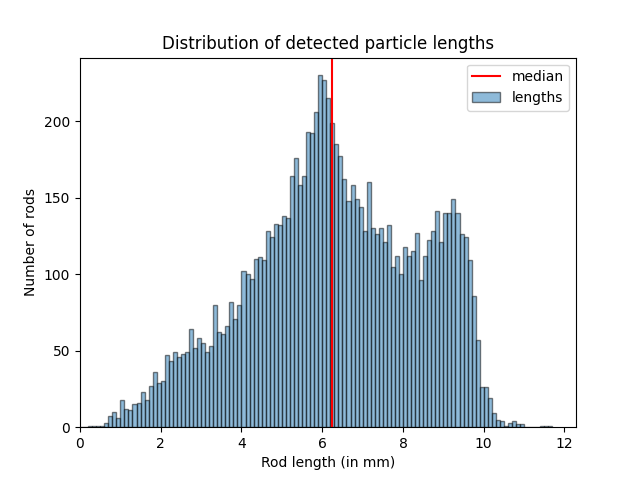

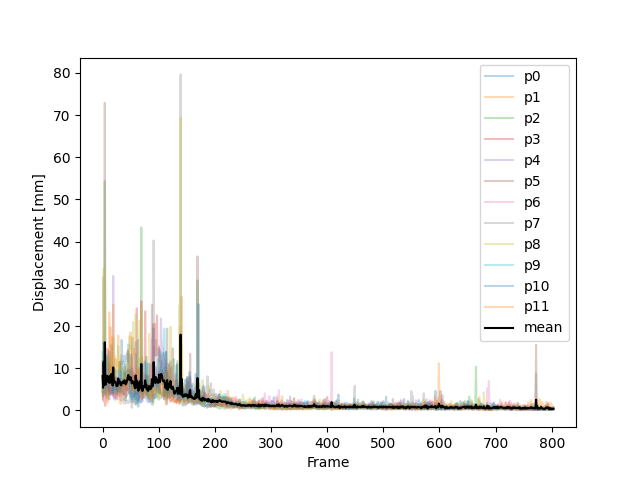

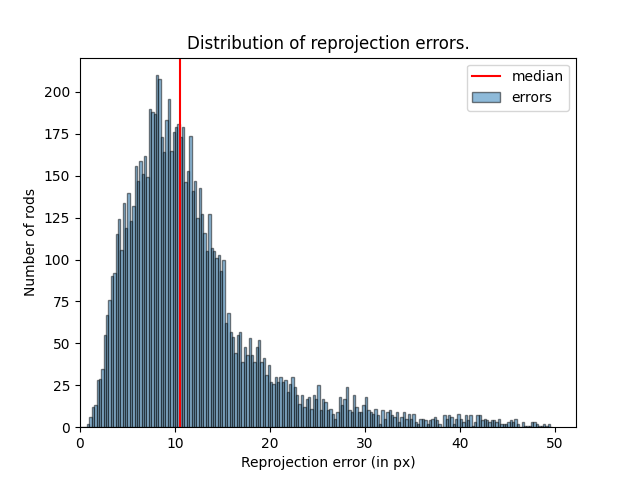

In [11]:
err_vis = np.array([])
len_vis = np.array([])
for err, l in zip(errs, lens):
    err_vis = np.concatenate([err_vis, err.flatten()])
    len_vis = np.concatenate([len_vis, l.flatten()])
vis.matching_results(err_vis, len_vis)


for file in out_folder.iterdir():
    tmp_data = pd.read_csv(file, index_col=0)
    tmp_3d = dl.extract_3d_data(tmp_data)
    vis.displacement_fwise(tmp_3d)

### Postprocessing of matching results
A re-matching of endpoints in 2D is required, because there is still a bug in
the ND-matching.
This is only done for the endpoints, NOT the rods, i.e. rod numbers shall stay
constant after the ND-matching.

In [3]:
input_folder = Path("./debugging_fixedCalib").resolve()
output = Path("debugging_fixedCalib_rematched").resolve()
output.mkdir(exist_ok=True)
frames = np.arange(100, 905, 1)
calibration_file = Path("../src/ParticleDetection/reconstruct_3D/example_calibration/Matlab/gp12.json").resolve()
transformation_file = Path("../src/ParticleDetection/reconstruct_3D/example_calibration/Matlab/world_transformation.json").resolve()
colors = ["blue", ]

In [4]:
errs, lens = match2D.match_csv_complex(
    str(input_folder), str(output), colors, "gp1", "gp2", frames,
    str(calibration_file), str(transformation_file), rematching=False
)

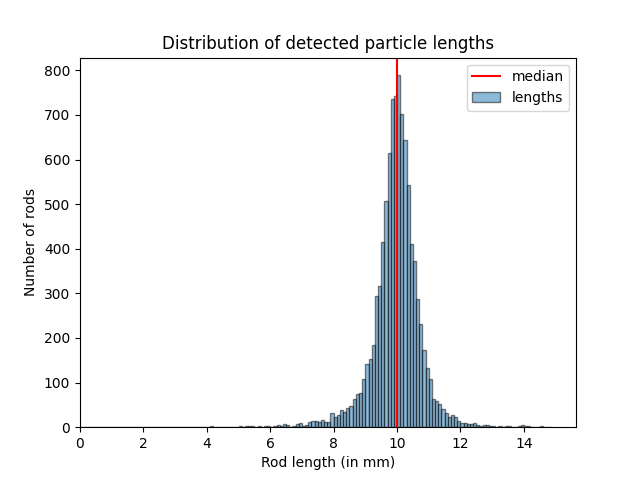

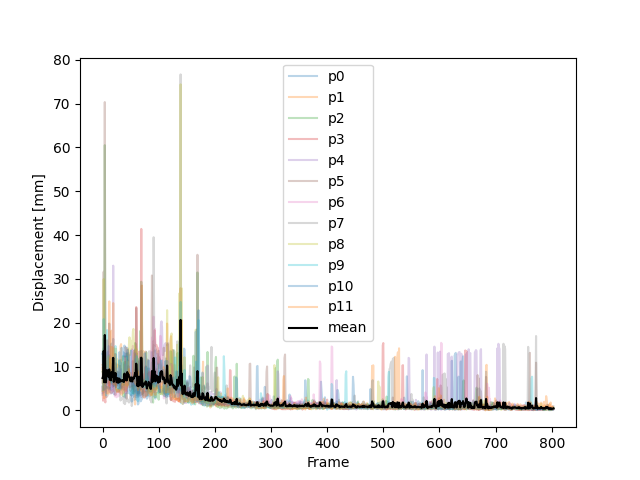

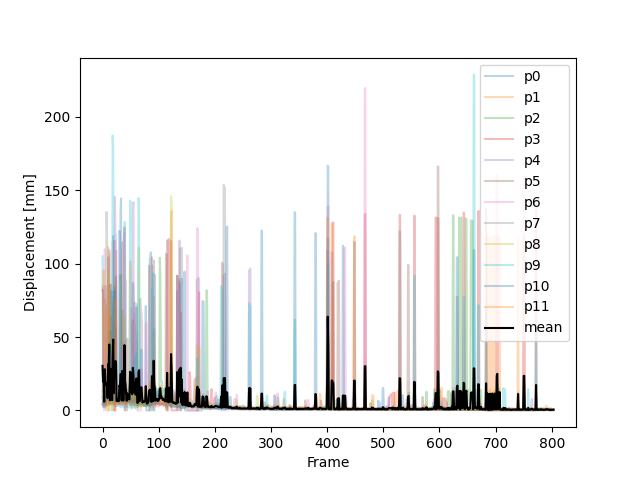

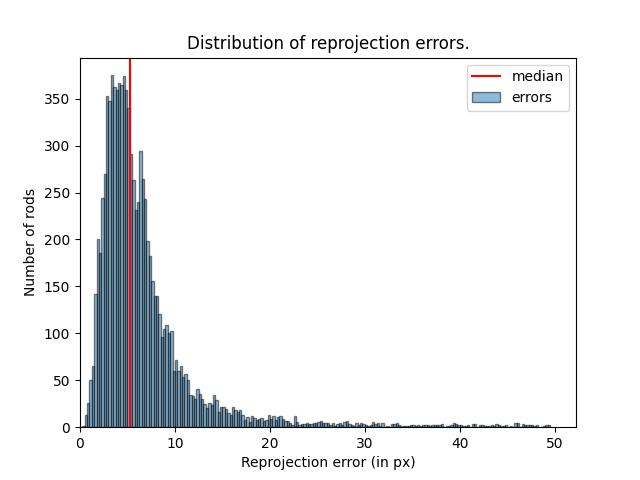

In [5]:
err_vis = np.array([])
len_vis = np.array([])
for err, l in zip(errs, lens):
    err_vis = np.concatenate([err_vis, err.flatten()])
    len_vis = np.concatenate([len_vis, l.flatten()])
vis.matching_results(err_vis, len_vis)

for file in output.iterdir():
    tmp_data = pd.read_csv(file, index_col=0)
    tmp_3d = dl.extract_3d_data(tmp_data)
    vis.displacement_fwise(tmp_3d)

## 4 Result Evaluation

In [6]:
from pathlib import Path
%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ParticleDetection.utils.data_loading as dl
import ParticleDetection.reconstruct_3D.visualization as vis

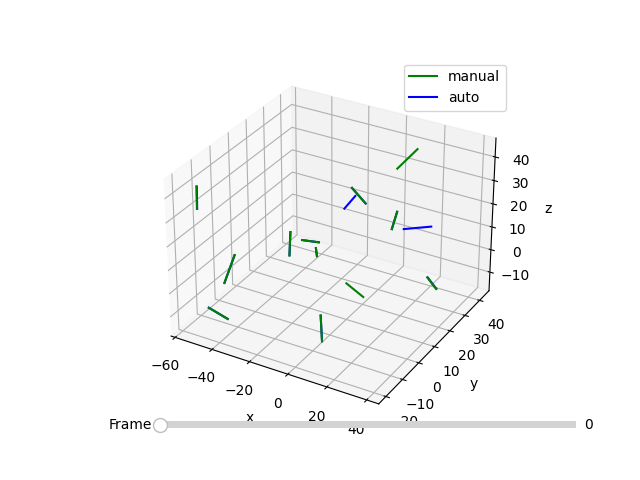

In [7]:
matched = Path("debug/rods_df_blue.csv").resolve()
matched = Path("debugging_fixedCalib_rematched/rods_df_blue.csv").resolve()

data = pd.read_csv(matched, index_col=0)
data_3d = dl.extract_3d_data(data)
orig = Path("../datasets/100-904_3Dt_13_blue/original/rods_df_blue.csv").resolve()
data_orig = pd.read_csv(orig, index_col=0)
data_orig.drop(columns=["x1r", "y1r", "z1r", "x2r", "y2r", "z2r"], inplace=True)
data_3d_orig = dl.extract_3d_data(data_orig)
vis.show_3D(data_3d, data_3d_orig)

In [8]:
data_aligned = data.copy()
cols2d = ['x1_gp1', 'y1_gp1', 'x2_gp1', 'y2_gp1', 'x1_gp2', 'y1_gp2', 'x2_gp2',
          'y2_gp2']
frames = data.frame.unique()
for frame in frames:
    for _, rod in data.loc[data.frame == frame].iterrows():
        for _, rod_orig in data_orig[data_orig.frame == frame].iterrows():
            # saved as 'aligned_rods_df.csv'
            if (rod_orig[cols2d].isin(rod[cols2d].values)).any():
                data_aligned.at[rod.name, "particle"] = rod_orig.particle

data_aligned.sort_values(by=["color", "frame", "particle"], inplace=True)
data_aligned.reset_index(drop=True, inplace=True)
data_aligned.to_csv(matched.parent / "aligned_rods_df_blue.csv")
data_aligned.head(12)

,x1,y1,z1,x2,y2,z2,x,y,z,l,...,y2_gp1,x1_gp2,y1_gp2,x2_gp2,y2_gp2,frame,color,particle,seen_gp1,seen_gp2
0,30.888566,23.736946,-1.200892,39.075229,19.112821,-1.082893,34.981898,21.424884,-1.141892,9.403080,...,347.511312,963.874657,432.402765,1049.163699,435.561618,100,blue,0,1,1
1,7.507303,4.390931,43.148246,12.217899,6.984038,36.305479,9.862601,5.687484,39.726862,8.702722,...,477.828054,725.429864,862.262443,777.556561,799.276018,100,blue,1,1,1
2,-40.744827,-14.655417,-11.778750,-49.973014,-15.491049,-8.677213,-45.358921,-15.073233,-10.227982,9.771246,...,648.285945,276.436573,342.455277,191.750891,371.098963,100,blue,2,1,1
3,27.140989,8.055360,35.604583,23.619937,9.316227,26.882219,25.380463,8.685794,31.243401,9.490376,...,443.076923,933.499564,795.133316,888.641067,709.792762,100,blue,4,1,1
4,-45.541140,-10.992275,0.253281,-45.626344,-4.985256,8.384112,-45.583742,-7.988766,4.318696,10.109499,...,567.374562,233.281977,450.453484,221.872057,526.519621,100,blue,5,1,1
5,16.064617,-3.643222,46.567248,9.859406,-2.731312,39.500626,12.962012,-3.187267,43.033937,9.448459,...,553.846154,797.104072,886.153846,747.149321,820.995475,100,blue,6,1,1
6,10.231953,33.483747,8.818957,17.881347,42.080266,6.388443,14.056650,37.782007,7.603700,11.760984,...,129.870072,768.227646,535.972628,860.091856,511.475505,100,blue,6,1,1
7,-38.781685,36.908231,-10.771881,-48.286790,37.043195,-12.071606,-43.534237,36.975713,-11.421743,9.594505,...,194.500000,243.030351,327.711895,141.911126,313.710771,100,blue,7,1,1
8,-49.872430,-19.676033,35.976798,-55.186126,-14.378588,40.792120,-52.529278,-17.027311,38.384459,8.915471,...,682.033648,194.753573,773.997353,126.122423,824.835242,100,blue,8,1,1
9,-50.416599,32.246744,-5.932867,-50.645905,31.731246,-16.309495,-50.531252,31.988995,-11.121181,10.391955,...,245.429864,124.817403,381.029294,125.943039,272.968211,100,blue,10,1,1


In [9]:
data_orig.head(12)

,x1,y1,z1,x2,y2,z2,x,y,z,l,...,x2_gp1,y2_gp1,x1_gp2,y1_gp2,x2_gp2,y2_gp2,particle,seen_gp1,seen_gp2,frame
0,30.693496,23.747025,-1.200534,38.838283,19.122088,-1.085060,34.765890,21.434556,-1.142797,9.367013,...,1012.126697,347.511312,963.874657,432.402765,1049.163699,435.561618,0,1,1,100
1,7.503337,4.373470,43.155897,12.210889,6.966717,36.318858,9.857113,5.670094,39.737377,8.696614,...,773.212670,451.764706,725.429864,862.262443,777.556561,799.276018,1,1,1,100
2,-40.590235,-14.691869,-11.777871,-49.823878,-15.540124,-8.689185,-45.207056,-15.115996,-10.233528,9.773417,...,215.155575,657.390938,276.436573,342.455277,191.750891,371.098963,2,1,1,100
3,21.130033,-4.498182,6.587853,11.563247,-3.349833,9.238543,16.346640,-3.924007,7.913198,9.993411,...,755.837104,553.846154,860.091856,511.475505,768.227646,535.972628,3,1,1,100
4,23.624720,9.305463,26.902496,27.156317,8.047745,35.653558,25.390518,8.676604,31.278027,9.520249,...,914.389140,443.076923,888.641067,709.792762,933.499564,795.133316,4,1,1,100
5,-45.586475,-10.993735,0.247988,-45.659768,-4.983952,8.390005,-45.623121,-7.988843,4.318997,10.120044,...,220.116686,567.374562,233.281977,450.453484,221.872057,526.519621,5,1,1,100
6,8.817392,30.309632,36.350442,13.798374,36.834513,41.930684,11.307883,33.572072,39.140563,9.925893,...,813.657486,129.870072,747.149321,820.995475,797.104072,886.153846,6,1,1,100
7,-48.374484,37.099933,-12.106373,-38.830510,36.945083,-10.786166,-43.602497,37.022508,-11.446270,9.636097,...,311.000000,194.500000,141.911126,313.710771,243.030351,327.711895,7,1,1,100
8,-49.969504,-19.713220,36.042124,-55.341550,-14.392946,40.900821,-52.655527,-17.053083,38.471473,8.987275,...,91.494069,682.033648,194.753573,773.997353,126.122423,824.835242,8,1,1,100
9,-39.509199,36.526341,-17.056234,-35.911890,31.941216,-9.647082,-37.710545,34.233779,-13.351658,9.426534,...,327.963801,236.742081,238.063457,261.537354,284.677476,341.447102,9,1,1,100


### Aligned evaluation

In [24]:
from pathlib import Path
%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ParticleDetection.utils.data_loading as dl
import ParticleDetection.reconstruct_3D.visualization as vis

In [2]:
path_aligned = Path("debug_rematched/aligned_rods_df_blue.csv").resolve()
data_aligned = pd.read_csv(path_aligned, index_col=0)
orig = Path("../datasets/100-904_3Dt_13_blue/original/rods_df_blue.csv").resolve()
data_orig = pd.read_csv(orig, index_col=0)
data_orig.drop(columns=["x1r", "y1r", "z1r", "x2r", "y2r", "z2r"], inplace=True)

In [25]:
data_3d = dl.extract_3d_data(data_aligned)
data_3d_orig = dl.extract_3d_data(data_orig)

[4.18328237 4.03253501 3.32637541 2.86030471 2.89609026 3.23381588
 3.56980825 1.33702663 1.50036006 2.50903074 3.83041284 3.74156739]


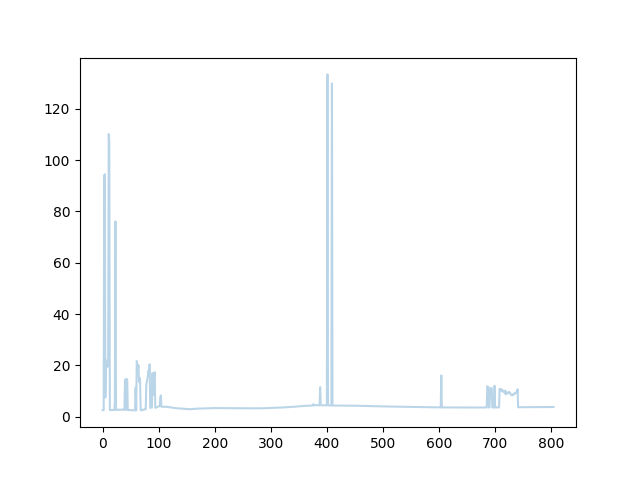

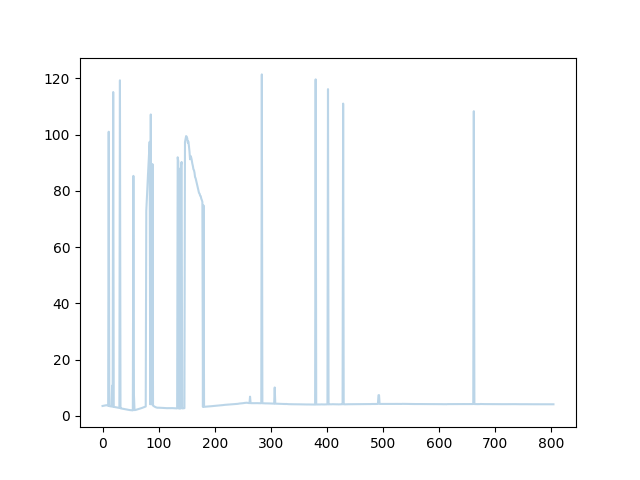

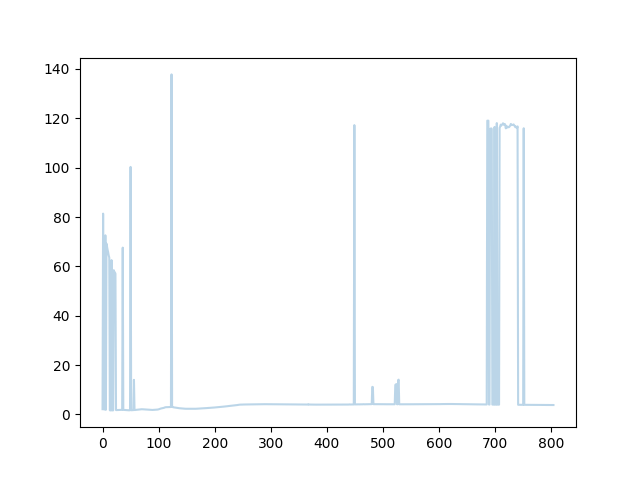

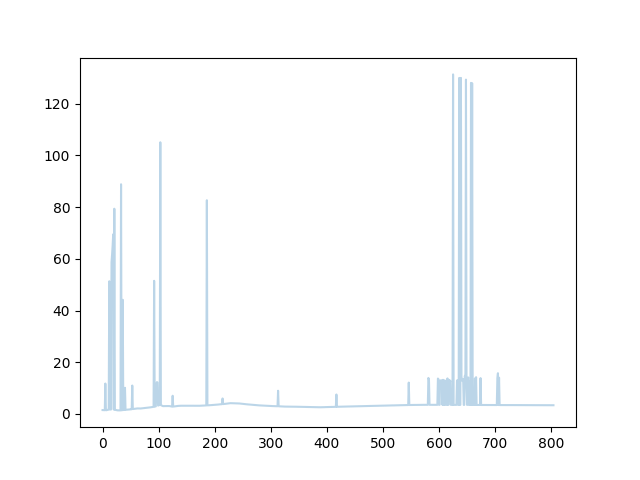

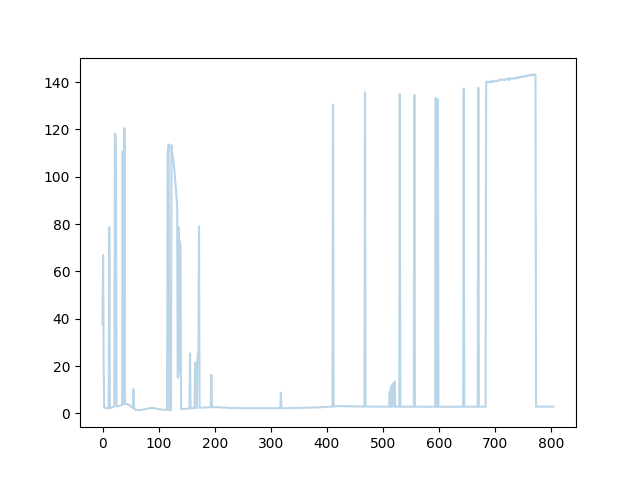

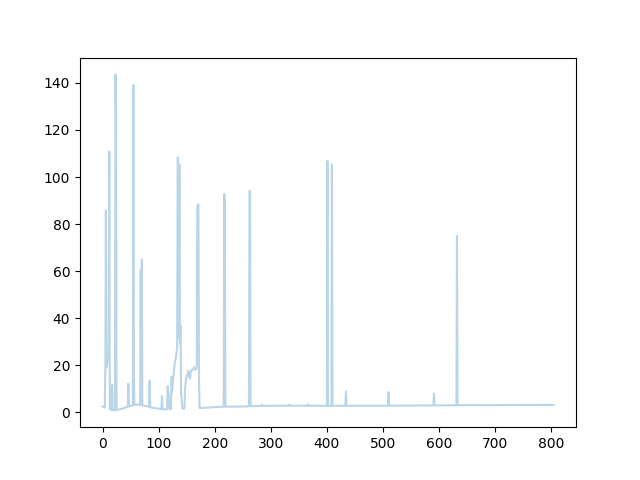

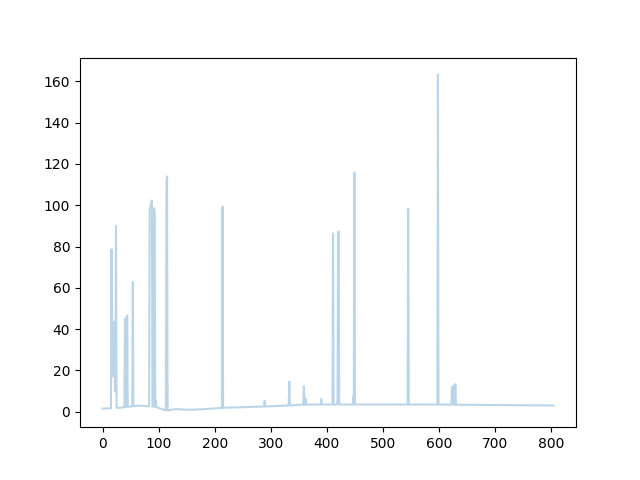

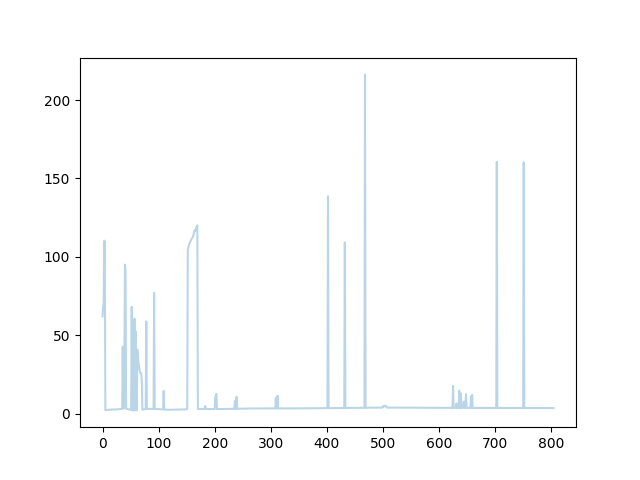

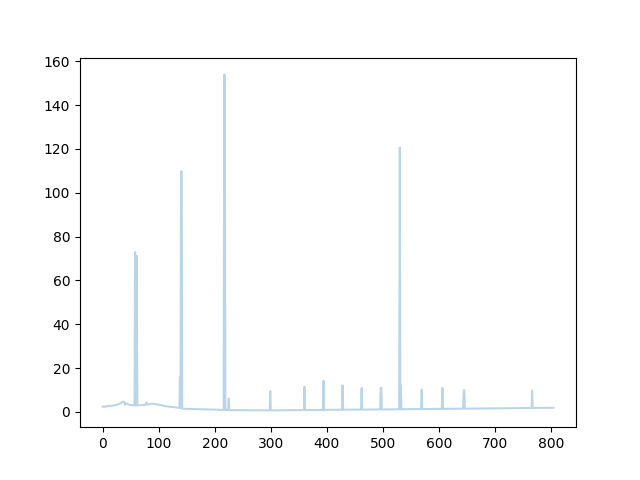

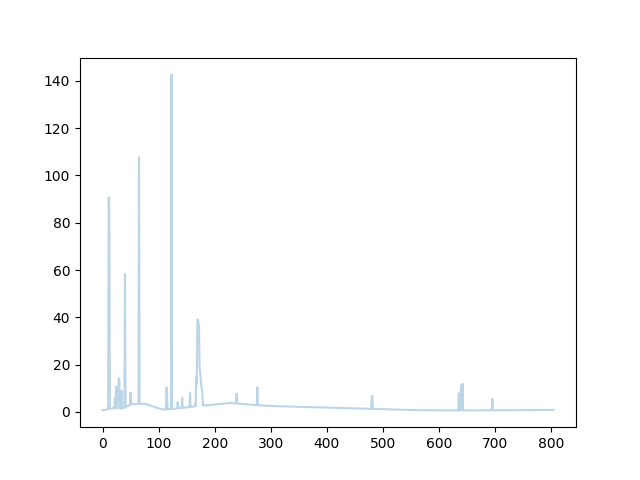

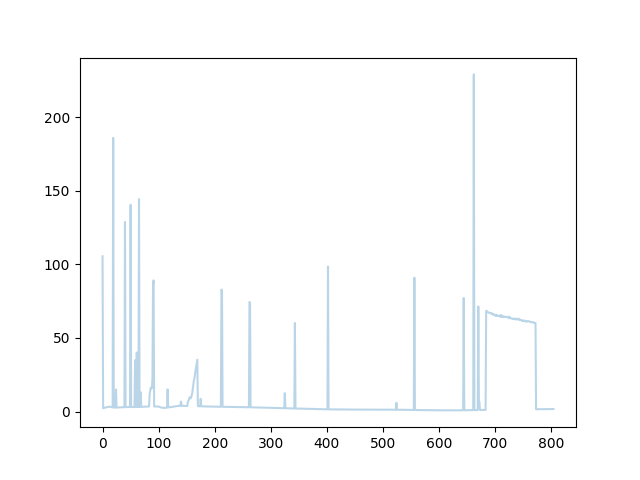

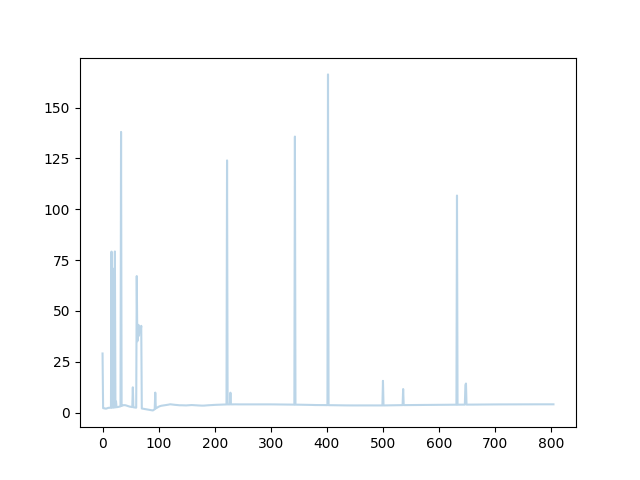

In [26]:
diff_3d = np.sum(np.linalg.norm(data_3d - data_3d_orig, axis=2), axis=-1).T
diff_3d_inv = np.sum(np.linalg.norm(data_3d[:,:,:, ::-1] - data_3d_orig, axis=2), axis=-1).T
min_dist = np.min(np.stack((diff_3d, diff_3d_inv)), axis=0)
print(np.median(min_dist, axis=1))
# plt.figure()
for rod_diff in min_dist[:]:
    plt.figure()
    plt.plot(rod_diff, alpha=0.3)
plt.show()